# RealWaste Dataset Preprocessing
This notebook preprocesses the RealWaste dataset from the local folder structure.

Dataset location: `realwaste/realwaste-main/RealWaste/`

The RealWaste dataset contains 9 classes of waste materials:
- Cardboard
- Food Organics
- Glass
- Metal
- Miscellaneous Trash
- Paper
- Plastic
- Textile Trash
- Vegetation


In [1]:
import sys, subprocess, pkgutil
print("Using Python:", sys.executable)

# install into THIS kernel's interpreter
subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "pip"])
subprocess.check_call([sys.executable, "-m", "pip", "install", "torch", "torchvision", "pillow", "matplotlib"])

import torch
print("Torch:", torch.__version__, "| CUDA available:", torch.cuda.is_available())


Using Python: d:\downloads_from_edge\engg123\venv\Scripts\python.exe
Torch: 2.6.0+cu124 | CUDA available: True


In [2]:
# Imports
from __future__ import annotations
import random
from pathlib import Path
from typing import List, Tuple, Optional, Dict

import numpy as np
import torch
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms

print("All imports successful.")


All imports successful.


In [3]:
# Reproducibility + device pick
# ------------------------------
def set_seed(seed: int = 56) -> None:
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def pick_device() -> torch.device:
    if torch.cuda.is_available():
        d = torch.device("cuda")
        print(f"[Device] CUDA: {torch.cuda.get_device_name(0)}")
        return d
    if hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
        print("[Device] MPS (Apple Metal)")
        return torch.device("mps")
    print("[Device] CPU")
    return torch.device("cpu")

def get_num_workers(requested_workers: int = 2) -> int:
    """
    Get the appropriate number of DataLoader workers for the current platform.
    
    On Windows, multiprocessing with DataLoaders can cause worker crashes due to
    the spawn method used for process creation. Setting num_workers=0 forces
    single-process loading which is more stable on Windows.
    
    Args:
        requested_workers: Desired number of workers (used on non-Windows platforms)
    
    Returns:
        Number of workers to use (0 on Windows, requested_workers otherwise)
    """
    import platform
    if platform.system() == 'Windows':
        print(f"[Platform] Windows detected: Using num_workers=0 (single-process loading)")
        print(f"           This avoids multiprocessing issues on Windows.")
        return 0
    return requested_workers


In [4]:
# Transforms
# ------------------------------
def build_transforms(img_size: int) -> Tuple[transforms.Compose, transforms.Compose]:
    mean, std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
    train_tf = transforms.Compose([
        transforms.Resize(256),
        transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ColorJitter(0.1, 0.1, 0.1, 0.03),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
    eval_tf = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
    return train_tf, eval_tf


In [5]:
# Dataset utils
# ------------------------------
def ext_filter(only_jpg: bool):
    """Filter for image extensions. RealWaste uses .jpg files."""
    return (lambda p: str(p).lower().endswith(".jpg")) if only_jpg else None

def stratified_split_indices(targets: List[int], val_ratio: float, test_ratio: float, seed: int):
    """
    Split dataset indices into train/val/test with stratification.
    
    Args:
        targets: List of class labels
        val_ratio: Validation split ratio (e.g., 0.2 for 20%)
        test_ratio: Test split ratio (e.g., 0.1 for 10%)
        seed: Random seed for reproducibility
    
    Returns:
        train_idx, val_idx, test_idx: Lists of indices for each split
    """
    rng = np.random.default_rng(seed)
    targets = np.array(targets)
    tr, va, te = [], [], []
    
    for c in np.unique(targets):
        idx = np.where(targets == c)[0]
        rng.shuffle(idx)
        
        n_total = len(idx)
        n_test = max(1, int(round(n_total * test_ratio))) if test_ratio > 0 else 0
        n_val = max(1, int(round(n_total * val_ratio)))
        
        te += idx[:n_test].tolist()
        va += idx[n_test:n_test + n_val].tolist()
        tr += idx[n_test + n_val:].tolist()
    
    rng.shuffle(tr)
    rng.shuffle(va)
    rng.shuffle(te)
    
    return tr, va, te

def load_realwaste_dataset(
    data_root: Path,
    img_size: int,
    val_ratio: float,
    test_ratio: float,
    seed: int,
    only_jpg: bool = True,
    batch_size: int = 64,
    num_workers: int = 2,
) -> Tuple[DataLoader, DataLoader, Optional[DataLoader], Dict]:
    """
    Loads the RealWaste dataset from local folder and creates DataLoaders.
    
    Args:
        data_root: Path to RealWaste dataset folder
        img_size: Target image size for resizing
        val_ratio: Validation split ratio (default: 0.2 = 20%)
        test_ratio: Test split ratio (default: 0.1 = 10%)
        seed: Random seed for reproducibility
        only_jpg: Filter to .jpg images only (RealWaste uses jpg)
        batch_size: Batch size for DataLoaders
        num_workers: Number of workers for DataLoaders
    
    Returns:
        train_loader, val_loader, test_loader, metadata dict
    """
    print(f"[RealWaste] Loading dataset from {data_root}")
    
    if not data_root.exists():
        raise ValueError(f"Dataset path does not exist: {data_root}")
    
    train_tf, eval_tf = build_transforms(img_size)
    filt = ext_filter(only_jpg)
    
    # Load raw dataset to get class info and targets
    raw = datasets.ImageFolder(str(data_root), transform=None, is_valid_file=filt)
    classes = raw.classes
    targets = getattr(raw, "targets", [lbl for _, lbl in raw.samples])
    
    print(f"[Dataset] Found {len(classes)} classes: {classes}")
    print(f"[Dataset] Total images: {len(raw)}")
    
    # Print class distribution
    print("\n[Dataset] Class distribution:")
    for i, class_name in enumerate(classes):
        count = sum(1 for t in targets if t == i)
        print(f"  {class_name:25s}: {count:4d} images")
    
    # Create stratified splits
    tr_idx, va_idx, te_idx = stratified_split_indices(targets, val_ratio, test_ratio, seed)
    
    # Create datasets with appropriate transforms
    tr_full = datasets.ImageFolder(str(data_root), transform=train_tf, is_valid_file=filt)
    va_full = datasets.ImageFolder(str(data_root), transform=eval_tf,  is_valid_file=filt)
    te_full = datasets.ImageFolder(str(data_root), transform=eval_tf,  is_valid_file=filt)
    
    train_ds = Subset(tr_full, tr_idx)
    val_ds   = Subset(va_full, va_idx)
    test_ds  = Subset(te_full, te_idx) if test_ratio > 0 else None
    
    # Create DataLoaders
    train_ld = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=num_workers, pin_memory=True)
    val_ld   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)
    test_ld  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True) if test_ds else None
    
    meta = {
        "classes": classes,
        "num_classes": len(classes),
        "img_size": img_size,
        "dataset_name": "RealWaste",
    }
    
    return train_ld, val_ld, test_ld, meta


In [6]:
# Summary helper
# ------------------------------
from torch.utils.data import Subset

def summarize_loaders(train_ld, val_ld, test_ld, meta, device):
    """Print a comprehensive summary of the data loaders."""
    
    def ds_len(obj):
        if obj is None:
            return 0
        # Accept DataLoader, Dataset, or Subset
        base = getattr(obj, "dataset", obj)
        return len(base)
    
    print("\n" + "="*60)
    print("DATA SUMMARY")
    print("="*60)
    print(f"Dataset: {meta.get('dataset_name', 'Unknown')}")
    print(f"Device: {device.type.upper()}")
    
    classes = meta.get("classes", [])
    print(f"\nNumber of classes: {len(classes)}")
    print(f"Classes: {classes}")
    
    print(f"\nDataset sizes:")
    print(f"  Train:      {ds_len(train_ld):5d} samples")
    print(f"  Validation: {ds_len(val_ld):5d} samples")
    print(f"  Test:       {ds_len(test_ld):5d} samples")
    
    total = ds_len(train_ld) + ds_len(val_ld) + ds_len(test_ld)
    print(f"  Total:      {total:5d} samples")
    
    if total > 0:
        train_pct = (ds_len(train_ld) / total) * 100
        val_pct = (ds_len(val_ld) / total) * 100
        test_pct = (ds_len(test_ld) / total) * 100
        print(f"\nSplit percentages:")
        print(f"  Train:      {train_pct:5.1f}%")
        print(f"  Validation: {val_pct:5.1f}%")
        print(f"  Test:       {test_pct:5.1f}%")
    
    try:
        # Peek one batch from training loader
        xb, yb = next(iter(train_ld))
        print(f"\nSample batch shape:")
        print(f"  Images: {tuple(xb.shape)}  (B, C, H, W)")
        print(f"  Labels: {tuple(yb.shape)}")
        print(f"  Image dtype: {xb.dtype}")
        print(f"  Image range: [{xb.min():.3f}, {xb.max():.3f}]")
    except Exception as e:
        print(f"\n[Warning] Could not fetch a sample batch: {e}")
    
    print("="*60 + "\n")


In [7]:
# ---- RUN PIPELINE IN NOTEBOOK ----

# Settings you can tweak
DATA_ROOT    = Path("realwaste/realwaste-main/RealWaste")
IMG_SIZE     = 224
BATCH_SIZE   = 64
NUM_WORKERS  = 2    # Will be auto-adjusted to 0 on Windows
VAL_RATIO    = 0.2  # 20% for validation
TEST_RATIO   = 0.1  # 10% for test (set to 0.0 for no test set)
SEED         = 56

# 1) Set seed + pick device
set_seed(SEED)
device = pick_device()

# 2) Adjust num_workers for platform compatibility
num_workers_adjusted = get_num_workers(NUM_WORKERS)

# 3) Load dataset and create DataLoaders
train_ld, val_ld, test_ld, meta = load_realwaste_dataset(
    data_root=DATA_ROOT,
    img_size=IMG_SIZE,
    val_ratio=VAL_RATIO,
    test_ratio=TEST_RATIO,
    seed=SEED,
    only_jpg=True,
    batch_size=BATCH_SIZE,
    num_workers=num_workers_adjusted,
)

# 4) Print summary
summarize_loaders(train_ld, val_ld, test_ld, meta, device)


[Device] CUDA: NVIDIA GeForce RTX 4070 Laptop GPU
[Platform] Windows detected: Using num_workers=0 (single-process loading)
           This avoids multiprocessing issues on Windows.
[RealWaste] Loading dataset from realwaste\realwaste-main\RealWaste
[Dataset] Found 9 classes: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
[Dataset] Total images: 4752

[Dataset] Class distribution:
  Cardboard                :  461 images
  Food Organics            :  411 images
  Glass                    :  420 images
  Metal                    :  790 images
  Miscellaneous Trash      :  495 images
  Paper                    :  500 images
  Plastic                  :  921 images
  Textile Trash            :  318 images
  Vegetation               :  436 images

DATA SUMMARY
Dataset: RealWaste
Device: CUDA

Number of classes: 9
Classes: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'T

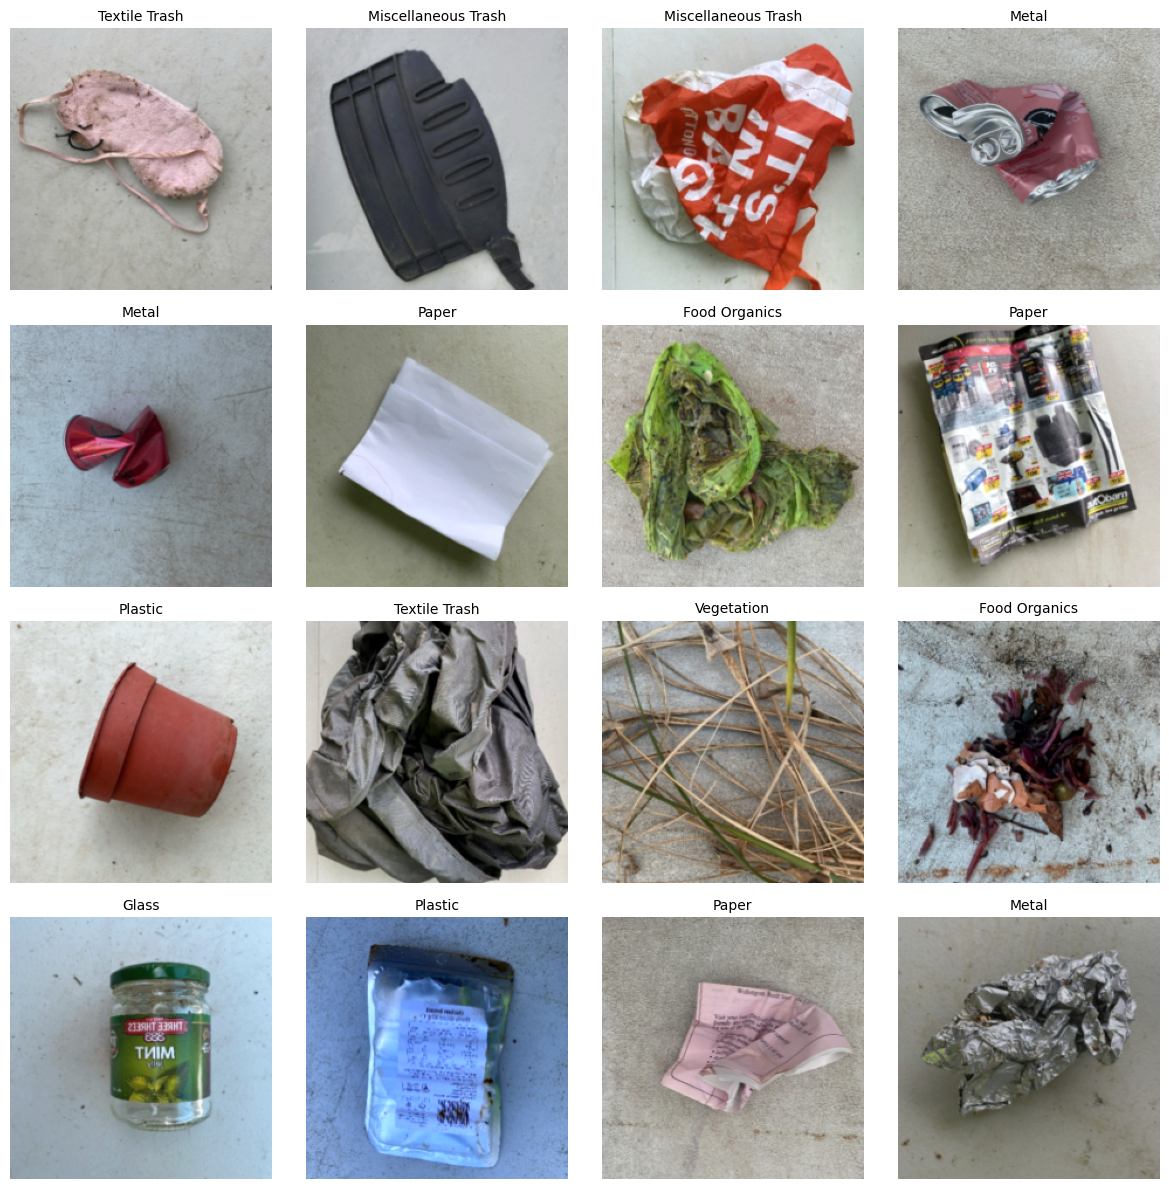

In [8]:
# Optional: Visualize some samples
# ------------------------------
import matplotlib.pyplot as plt

def visualize_samples(loader, meta, num_samples=16):
    """
    Visualize a grid of sample images from the loader.
    
    Args:
        loader: DataLoader to sample from
        meta: Metadata dictionary with class names
        num_samples: Number of samples to display
    """
    classes = meta.get('classes', [])
    
    # Get a batch
    images, labels = next(iter(loader))
    images = images[:num_samples]
    labels = labels[:num_samples]
    
    # Denormalize images
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    images = images * std + mean
    images = torch.clamp(images, 0, 1)
    
    # Create grid
    grid_size = int(np.ceil(np.sqrt(num_samples)))
    fig, axes = plt.subplots(grid_size, grid_size, figsize=(12, 12))
    axes = axes.flatten()
    
    for idx, (img, label) in enumerate(zip(images, labels)):
        if idx >= len(axes):
            break
        
        # Convert to numpy and transpose
        img_np = img.permute(1, 2, 0).numpy()
        
        axes[idx].imshow(img_np)
        axes[idx].axis('off')
        if classes:
            axes[idx].set_title(f"{classes[label.item()]}", fontsize=10)
        else:
            axes[idx].set_title(f"Label: {label.item()}")
    
    # Hide unused subplots
    for idx in range(len(images), len(axes)):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()

# Uncomment to visualize samples
visualize_samples(train_ld, meta, num_samples=16)


In [9]:
# Optional: Test a single batch
# ------------------------------
def test_batch_loading(loader, device):
    """
    Test loading a batch and moving it to the target device.
    """
    print("\n[Test] Loading a batch...")
    images, labels = next(iter(loader))
    
    print(f"  CPU - Images: {images.shape}, Labels: {labels.shape}")
    print(f"  Memory: {images.element_size() * images.nelement() / (1024**2):.2f} MB")
    
    # Move to device
    images = images.to(device)
    labels = labels.to(device)
    
    print(f"  {device.type.upper()} - Images: {images.shape}, Labels: {labels.shape}")
    print(f"  Images device: {images.device}")
    print("  ✓ Batch loading successful!")

# Uncomment to test batch loading
# test_batch_loading(train_ld, device)


In [10]:
# Optional: Export loaders for training scripts
# ------------------------------
# You can save the metadata and use these loaders in your training notebook
print("\n[Export] DataLoaders ready for training:")
print(f"  - train_ld: {len(train_ld)} batches ({len(train_ld.dataset)} samples)")
print(f"  - val_ld:   {len(val_ld)} batches ({len(val_ld.dataset)} samples)")
if test_ld:
    print(f"  - test_ld:  {len(test_ld)} batches ({len(test_ld.dataset)} samples)")
print(f"  - meta:     {meta}")
print("\nYou can now use these loaders in your training script!")



[Export] DataLoaders ready for training:
  - train_ld: 52 batches (3326 samples)
  - val_ld:   15 batches (950 samples)
  - test_ld:  8 batches (476 samples)
  - meta:     {'classes': ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation'], 'num_classes': 9, 'img_size': 224, 'dataset_name': 'RealWaste'}

You can now use these loaders in your training script!
